In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python  



#The functions needed to evaluate my models
def root_mean_squared(observe, simul):
    return (np.mean((observe - simul)**2))**.5

def Rroot_mean_squared(observe, simul):
    return (np.mean(((observe - simul)/observe)**2))**.5
def Bias(observe, simul):
    return np.mean(observe - simul)

# 1. Import the data and visualize the first rows

In [2]:
df = pd.read_csv("data_final_419.csv").iloc[:, 1:]
df.head()

,Station,Sup_Diffus,HISTO_1,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_6,HISTO_7,HISTO_sum,...,10ans,20ans,50ans,100ans,log_P,log_q2,log_q20,log_q100,V1,V2
0,10802,1911.0,0.000477,76.194454,1.406637,0.406317,0.117828,21.871711,0.002575,6153492,...,716.035565,879.703500,1097.930829,1263.971855,6.496986,5.848621,6.779585,7.142014,1.492714,-0.840098
1,11003,1687.0,0.000000,86.192454,2.687723,0.717252,0.321026,10.081545,0.000000,4680914,...,639.762686,747.810174,887.939880,992.552494,6.537474,5.922095,6.617149,6.900280,1.286977,-0.856600
2,11508,555.0,14.102107,61.484997,6.493141,8.313327,2.500343,6.650793,0.455292,1500822,...,80.596780,89.759758,101.620293,110.508096,6.468192,4.036299,4.497137,4.705089,-0.238767,1.081554
3,20404,670.0,0.005742,81.649372,1.556526,0.975507,3.952303,11.860550,0.000000,2085066,...,222.630699,254.596659,295.973315,326.979297,6.483294,4.934279,5.539681,5.789897,0.617317,-0.870222
4,21407,772.0,0.001557,89.868809,1.691733,1.313601,1.195126,5.880643,0.048532,2499651,...,343.199220,400.004822,474.411358,530.344768,6.492895,5.334301,5.991477,6.273527,0.855087,-0.220233


# 2. Transformation and visualization

* Here the dependantes variables to be used are transformed to normal score. 

* We do a scatter plot between the variables of interest to check their correlations

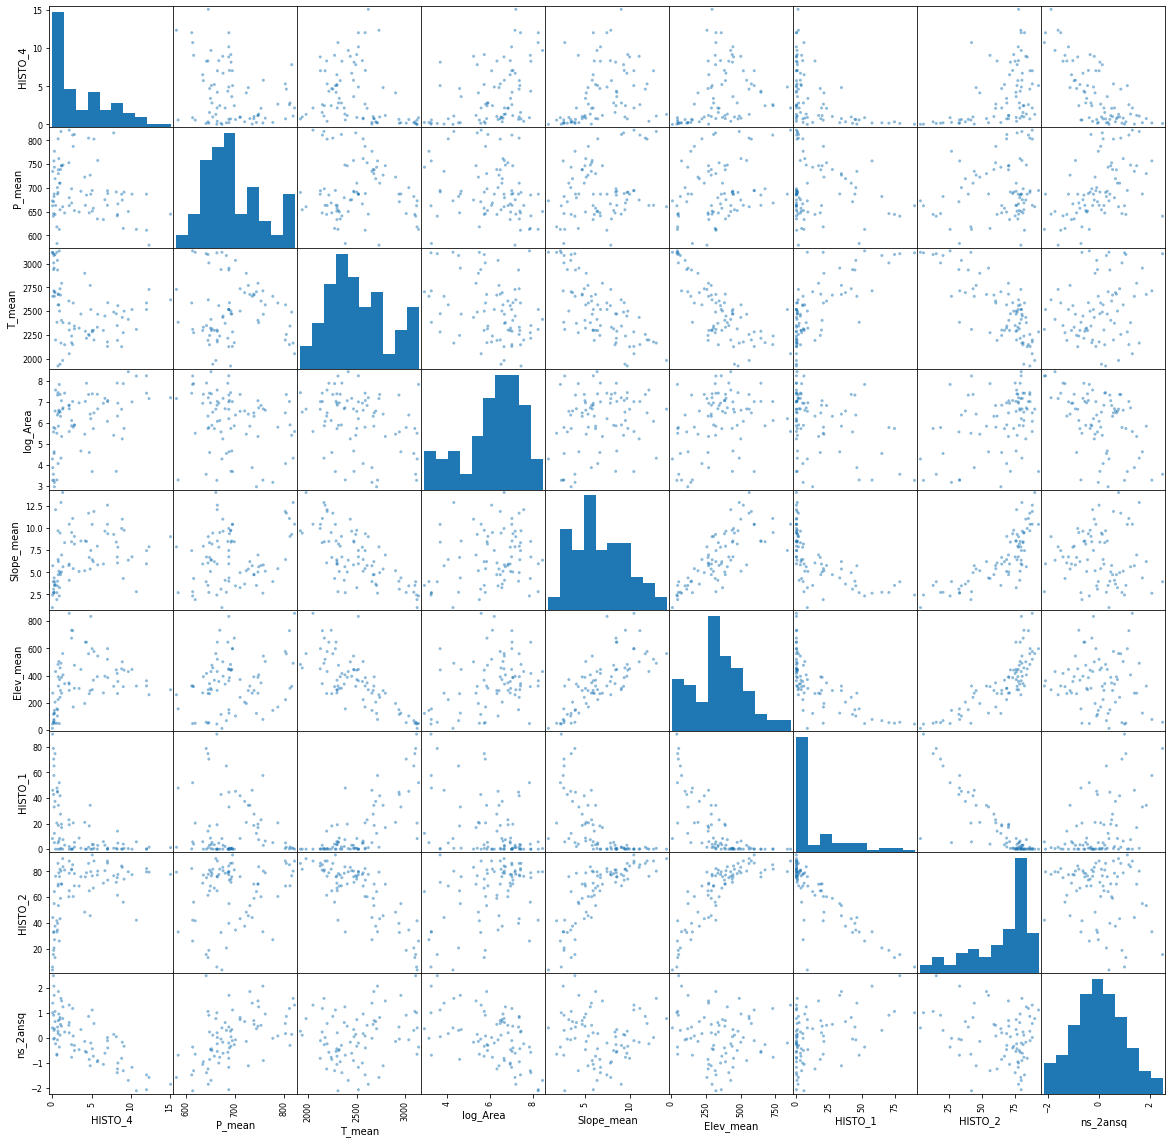

In [4]:

df["2ansq"] = (df["2ans"])/(df["Sup_Diffus"])
df["Qmeanq"] = (df["Mean_Annual_Max"])/(df["Sup_Diffus"])

df["ns_2ansq"], trans_vr,trans_ns  = geostats.nscore(df, "2ansq")



df["ns_Qmeanq"], _, _ = geostats.nscore(df, "Qmeanq")




features = ["HISTO_4", "P_mean", "T_mean", "log_Area","Slope_mean",
            "Elev_mean", "HISTO_1", "HISTO_2", "ns_2ansq"]


pd.plotting.scatter_matrix(df[features], figsize=(20, 20));


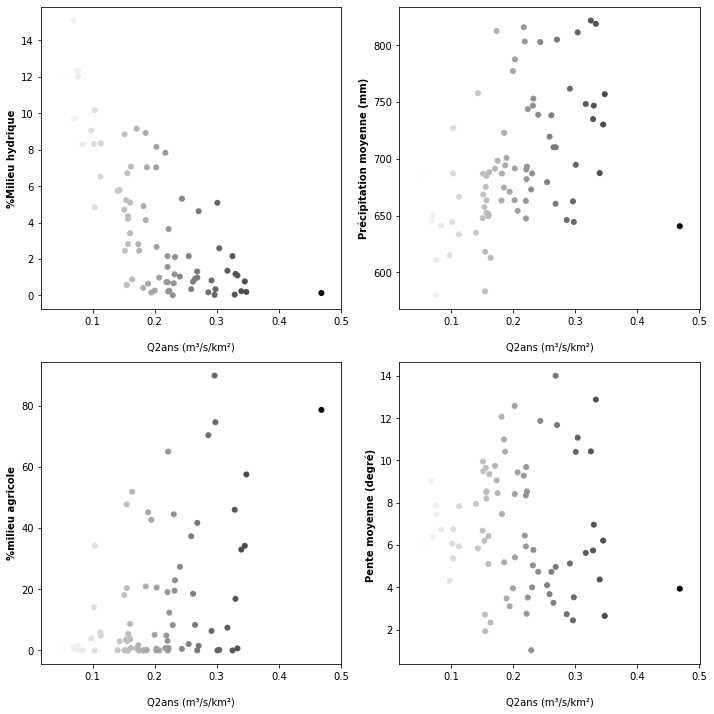

In [255]:
features = ["HISTO_4","P_mean", "HISTO_1", "Slope_mean"]
name_feature = ["%Milieu hydrique", "Précipitation moyenne (mm)", "%milieu agricole", "Pente moyenne (degré) "]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

cmap = plt.cm.binary

for i, ax in enumerate(axes.flatten()):
    ax.scatter(df["2ansq"], df[features[i]], c=df["2ansq"], 
               cmap=cmap, s=25)
    ax.set_xlabel("\nQ2ans (m³/s/km²)")
    ax.set_ylabel(name_feature[i], weight="bold")

plt.tight_layout(True)

plt.savefig("scatter_plot.jpg", format="jpg")

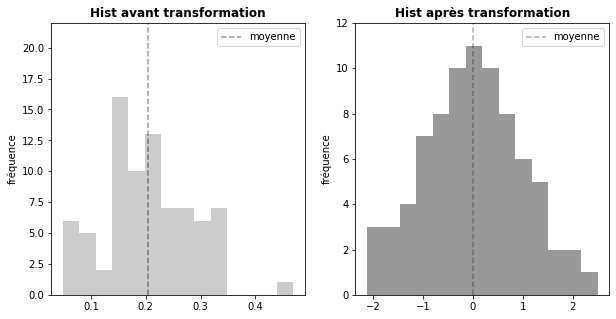

In [303]:
plt.figure(figsize=(10, 5))
q2_min, q2_max = df["2ansq"].min(), df["2ansq"].max()
ns_q2_min, ns_q2_max = df["ns_2ansq"].min(), df["ns_2ansq"].max()
plt.subplot(121)


plt.hist(df["2ansq"], bins=np.linspace(q2_min, q2_max, 15), color="k", alpha=0.2);
plt.vlines(df["2ansq"].mean(), 0, 22, ls="--", alpha=0.4, label="moyenne")
plt.legend()
plt.ylim(0, 22)
plt.ylabel("fréquence")
plt.title("Hist avant transformation", weight="bold")
plt.subplot(122)
plt.hist(df["ns_2ansq"], bins=np.linspace(ns_q2_min, ns_q2_max, 15), color="k", alpha=0.4);
plt.vlines(df["ns_2ansq"].mean(), 0, 12, ls="--", alpha=0.3, label="moyenne")
plt.ylim(0, 12)
plt.ylabel("fréquence")
plt.title("Hist après transformation", weight="bold")
plt.legend();

plt.savefig("histo.jpg", format="jpg")

* Create a function build upon the backtr method of geostats to back transforme the independantes variables from normal distribution to the original distribution

In [1]:

backtr_2ans = \
lambda df, colname: geostats.backtr(df, colname, trans_vr, trans_ns, zmin=-999, zmax=999, ltail=1, ltpar=0, utail=1, utpar=0)

# 3. Canonical correlation analysis (cca)

* perfom the cca to determine a new base where the correlation between the independantes and the dependante variables is maximized 
* plotting of the stations in the canonical space with a heatmap. Give an idea of the spatial continuity

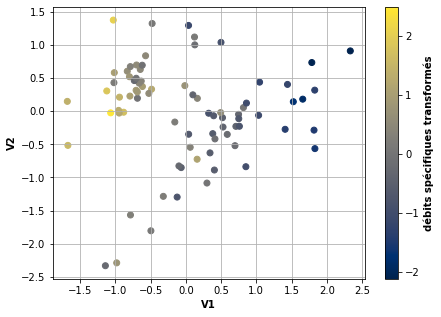

In [316]:
from sklearn.cross_decomposition import CCA
from sklearn.manifold import MDS




cca = CCA(n_components=2)
mds = MDS(n_components=2)

df["T_HISTO_4"] = np.sqrt(df["HISTO_4"])

df["T_HISTO_1"] = np.sqrt(df["HISTO_1"])

df["T_P_mean"] = np.sqrt(df["P_mean"])

features = ["HISTO_4","P_mean", "HISTO_1", "Slope_mean"]
X = np.sqrt(df[features].values)
Y = df[["ns_2ansq", "ns_Qmeanq"]]


X_mds = mds.fit_transform(X)

X_cca, Y_cca = cca.fit_transform(X, Y)

df["V1_cca"] = X_cca[:, 0].copy()
df["V2_cca"] = X_cca[:, 1].copy()

df["V1_mds"] = X_mds[:, 0]
df["V2_mds"] = X_mds[:, 1]

plt.figure(figsize=(7, 5))
cmap = plt.cm.cividis
plt.scatter(X_cca[:, 0], X_cca[:, 1], c=df["ns_2ansq"], cmap=cmap)
plt.grid(True)
clbar = plt.colorbar()
clbar.set_label("débits spécifiques transformés", weight="bold")
plt.xlabel("V1", weight="bold")
plt.ylabel("V2", weight="bold")
plt.savefig("data_posting.jpg", format="jpg")

# 4. Variogram modeling

* Compute the distance matrice to get an idea of the maximum distance between the points
* compute the variogram map using geostatpy
* plot the experimental variogram in different directions to check anisotropy
* Chose the direction of max anisotropy and fit a theorical variogram

In [7]:

D_cca = np.zeros((df.shape[0], df.shape[0]))

vario_cca = np.zeros((df.shape[0], df.shape[0]))
for i in range(df.shape[0]):
    xy1_cca = df[["V1_cca", "V2_cca"]].iloc[i, :]
    xy1_mds = df[["V1_mds", "V2_mds"]].iloc[i, :]
    v1_cca = df["ns_2ansq"].iloc[i]
    for j in range(df.shape[0]):
        xy2_cca = df[["V1_cca", "V2_cca"]].iloc[j, :]
        xy2_mds = df[["V1_mds", "V2_mds"]].iloc[j, :]
        D_cca[i, j] = np.linalg.norm((xy1_cca - xy2_cca))

        
        v2_cca = df["ns_2ansq"].iloc[j]
        vario_cca[i, j] = (v1_cca - v2_cca)**2
        
print("               The maximum distance is: ", D_cca.max())



10.211944952606878 4.755393022131685


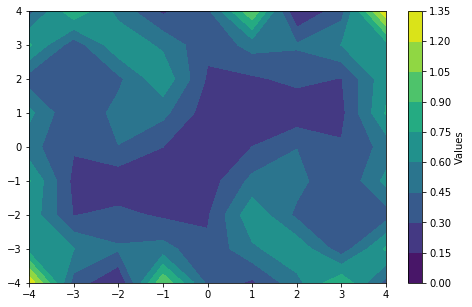

In [10]:
nxlag = 4; dxlag= 0.2
tmin=-999; tmax=999
vmap_cca, npmap_cca = geostats.varmapv(df, "V1_cca", "V2_cca", "ns_2ansq", tmin=tmin, tmax=tmax, 
                              nxlag=nxlag, nylag=nxlag, dxlag=dxlag, dylag=dxlag, minnp=4, isill=1)

plt.figure(figsize=(8, 5))
XX, YY = np.meshgrid(np.linspace(-nxlag, nxlag, vmap_cca.shape[0]), np.linspace(-nxlag, nxlag, vmap_cca.shape[0]))

plt.contourf(XX, YY, vmap_cca)
cbars = plt.colorbar()
cbars.set_label("Values")

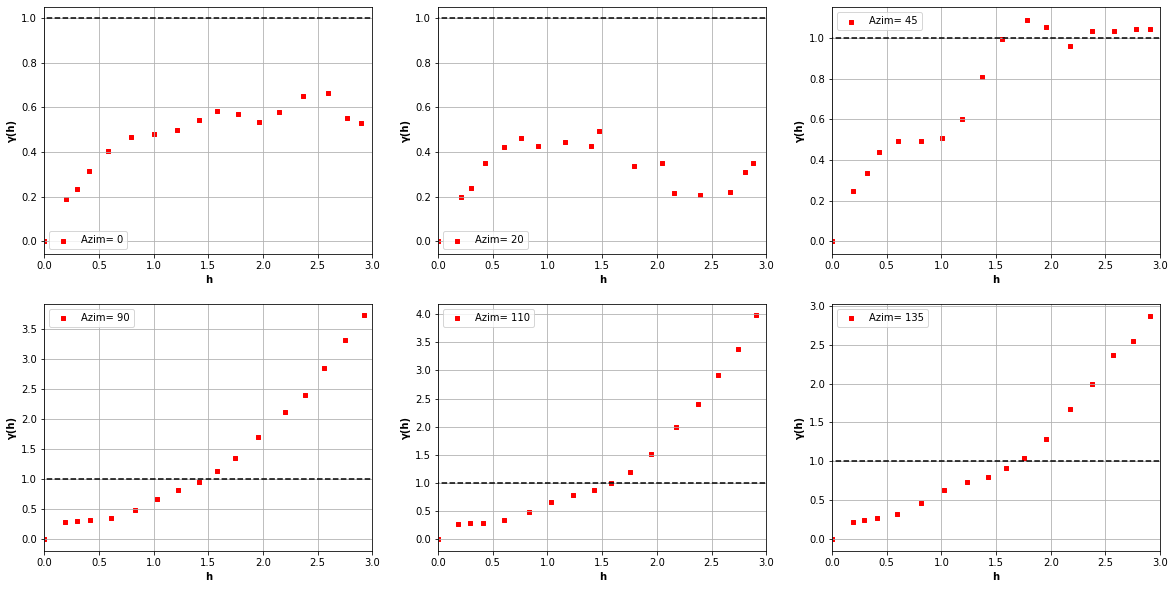

In [328]:
fig, axes = plt.subplots(2,3, figsize=(20,10))

for i, azim in enumerate([0, 20, 45, 90, 110, 135]):

    tmin = -9999 ; tmax= 9999; xlag= 0.2; xltol= 0.3; nlag=16
    lag_cca, gamma_cca, npairs = geostats.gamv(df, "V1_cca", "V2_cca", "ns_2ansq", 
                                               tmin=tmin, tmax=tmax, xlag=xlag, xltol=xltol, 
                  nlag=nlag, azm=azim, atol=azim/2, bandwh=999.9, isill=0)

    axes.flatten()[i].scatter(lag_cca[:-1], gamma_cca[:-1], label="Azim= "+str(azim), c="r", s=20, marker="s")
    axes.flatten()[i].grid(True)
    axes.flatten()[i].plot([-2, 5], [1, 1], ls="--", c="k")
    axes.flatten()[i].set_xlim(0, 3)
    axes.flatten()[i].legend()
    axes.flatten()[i].set_xlabel("h", weight="bold")
    axes.flatten()[i].set_ylabel("γ(h)", weight="bold")


plt.savefig("Vario_expérimentals.jpg", format="jpg")

## Variogram fitting

 x,y,z offsets = 0.2121320341655867,0.21213203454634177


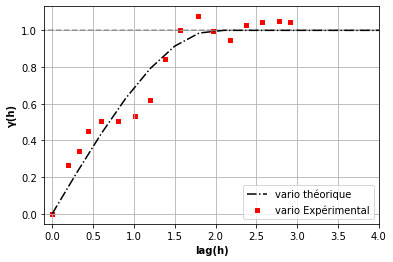

In [331]:
nug = 0; nst=1; it1=1; cc1 = 1; hmax1= 2;  hmin1 =1.5
it2=1; cc2 = 0; hmax2= 100;  hmin2=1; azi1=45
tmin = -9999 ; tmax= 9999; xlag= 0.20; xltol= 0.3;  azi2=45
nlag = 16
azim = 45

lag_cca, gamma_cca, npairs = geostats.gamv(df, "V1_cca", "V2_cca", "ns_2ansq", 
                                           tmin=tmin, tmax=tmax, xlag=xlag, xltol=xltol, 
                                           nlag=nlag, azm=azim, atol=20, bandwh=999.9, isill=0)

vario_cca = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmax1,hmin1)




index90, h90, gam90, cov90, ro90, = geostats.vmodel(nlag, 0.3, azim, vario_cca)


plt.hlines(1, -2, 10, ls="--", alpha=0.3)
plt.xlim(-0.1,4 )

plt.scatter(lag_cca[:-1], gamma_cca[:-1], s=20, c="r", marker="s", label="vario Expérimental")
plt.plot(h90, gam90, ls="-.", c="k", label="vario théorique")
plt.grid(True)
plt.legend()
plt.xlabel("lag(h)", weight="bold")
plt.ylabel("γ(h)", weight="bold")
plt.savefig("Vario_theo.jpg", format="jpg")

# 5. Kriging 

* Perform the kriging using the fitted variogram
* plot the kriging variance map and kriging estimation map

In [338]:
XX, YY = np.meshgrid(np.linspace(df["V1_cca"].min(), df["V1_cca"].max(), 100), np.linspace(df["V2_cca"].min(), df["V2_cca"].max(), 100))
ndmin = 0; ndmax=50

VV = []
VVariance = []

dat = pd.DataFrame({"V1_cca":XX.flatten(), "V2_cca":YY.flatten(), "ns_2ansq":np.array([0]*10000)})



    
VV, VVariance= geostats.kb2d_locations(df, "V1_cca", "V2_cca", "ns_2ansq", -999, 999, 
                                                 dat, "V1_cca", "V2_cca", 
                                                 ndmin=ndmin, ndmax=ndmax, radius=10, 
                                                 ktype=0, skmean=0, vario=vario_cca)


Working on location 0
Working on location 1
Working on location 2
Working on location 3
Working on location 4
Working on location 5
Working on location 6
Working on location 7
Working on location 8
Working on location 9
Working on location 10
Working on location 11
Working on location 12
Working on location 13
Working on location 14
Working on location 15
Working on location 16
Working on location 17
Working on location 18
Working on location 19
Working on location 20
Working on location 21
Working on location 22
Working on location 23
Working on location 24
Working on location 25
Working on location 26
Working on location 27
Working on location 28
Working on location 29
Working on location 30
Working on location 31
Working on location 32
Working on location 33
Working on location 34
Working on location 35
Working on location 36
Working on location 37
Working on location 38
Working on location 39
Working on location 40
Working on location 41
Working on location 42
Working on location 4

Working on location 360
Working on location 361
Working on location 362
Working on location 363
Working on location 364
Working on location 365
Working on location 366
Working on location 367
Working on location 368
Working on location 369
Working on location 370
Working on location 371
Working on location 372
Working on location 373
Working on location 374
Working on location 375
Working on location 376
Working on location 377
Working on location 378
Working on location 379
Working on location 380
Working on location 381
Working on location 382
Working on location 383
Working on location 384
Working on location 385
Working on location 386
Working on location 387
Working on location 388
Working on location 389
Working on location 390
Working on location 391
Working on location 392
Working on location 393
Working on location 394
Working on location 395
Working on location 396
Working on location 397
Working on location 398
Working on location 399
Working on location 400
Working on locat

Working on location 707
Working on location 708
Working on location 709
Working on location 710
Working on location 711
Working on location 712
Working on location 713
Working on location 714
Working on location 715
Working on location 716
Working on location 717
Working on location 718
Working on location 719
Working on location 720
Working on location 721
Working on location 722
Working on location 723
Working on location 724
Working on location 725
Working on location 726
Working on location 727
Working on location 728
Working on location 729
Working on location 730
Working on location 731
Working on location 732
Working on location 733
Working on location 734
Working on location 735
Working on location 736
Working on location 737
Working on location 738
Working on location 739
Working on location 740
Working on location 741
Working on location 742
Working on location 743
Working on location 744
Working on location 745
Working on location 746
Working on location 747
Working on locat

Working on location 1059
Working on location 1060
Working on location 1061
Working on location 1062
Working on location 1063
Working on location 1064
Working on location 1065
Working on location 1066
Working on location 1067
Working on location 1068
Working on location 1069
Working on location 1070
Working on location 1071
Working on location 1072
Working on location 1073
Working on location 1074
Working on location 1075
Working on location 1076
Working on location 1077
Working on location 1078
Working on location 1079
Working on location 1080
Working on location 1081
Working on location 1082
Working on location 1083
Working on location 1084
Working on location 1085
Working on location 1086
Working on location 1087
Working on location 1088
Working on location 1089
Working on location 1090
Working on location 1091
Working on location 1092
Working on location 1093
Working on location 1094
Working on location 1095
Working on location 1096
Working on location 1097
Working on location 1098


Working on location 1403
Working on location 1404
Working on location 1405
Working on location 1406
Working on location 1407
Working on location 1408
Working on location 1409
Working on location 1410
Working on location 1411
Working on location 1412
Working on location 1413
Working on location 1414
Working on location 1415
Working on location 1416
Working on location 1417
Working on location 1418
Working on location 1419
Working on location 1420
Working on location 1421
Working on location 1422
Working on location 1423
Working on location 1424
Working on location 1425
Working on location 1426
Working on location 1427
Working on location 1428
Working on location 1429
Working on location 1430
Working on location 1431
Working on location 1432
Working on location 1433
Working on location 1434
Working on location 1435
Working on location 1436
Working on location 1437
Working on location 1438
Working on location 1439
Working on location 1440
Working on location 1441
Working on location 1442


Working on location 1750
Working on location 1751
Working on location 1752
Working on location 1753
Working on location 1754
Working on location 1755
Working on location 1756
Working on location 1757
Working on location 1758
Working on location 1759
Working on location 1760
Working on location 1761
Working on location 1762
Working on location 1763
Working on location 1764
Working on location 1765
Working on location 1766
Working on location 1767
Working on location 1768
Working on location 1769
Working on location 1770
Working on location 1771
Working on location 1772
Working on location 1773
Working on location 1774
Working on location 1775
Working on location 1776
Working on location 1777
Working on location 1778
Working on location 1779
Working on location 1780
Working on location 1781
Working on location 1782
Working on location 1783
Working on location 1784
Working on location 1785
Working on location 1786
Working on location 1787
Working on location 1788
Working on location 1789


Working on location 2097
Working on location 2098
Working on location 2099
Working on location 2100
Working on location 2101
Working on location 2102
Working on location 2103
Working on location 2104
Working on location 2105
Working on location 2106
Working on location 2107
Working on location 2108
Working on location 2109
Working on location 2110
Working on location 2111
Working on location 2112
Working on location 2113
Working on location 2114
Working on location 2115
Working on location 2116
Working on location 2117
Working on location 2118
Working on location 2119
Working on location 2120
Working on location 2121
Working on location 2122
Working on location 2123
Working on location 2124
Working on location 2125
Working on location 2126
Working on location 2127
Working on location 2128
Working on location 2129
Working on location 2130
Working on location 2131
Working on location 2132
Working on location 2133
Working on location 2134
Working on location 2135
Working on location 2136


Working on location 2445
Working on location 2446
Working on location 2447
Working on location 2448
Working on location 2449
Working on location 2450
Working on location 2451
Working on location 2452
Working on location 2453
Working on location 2454
Working on location 2455
Working on location 2456
Working on location 2457
Working on location 2458
Working on location 2459
Working on location 2460
Working on location 2461
Working on location 2462
Working on location 2463
Working on location 2464
Working on location 2465
Working on location 2466
Working on location 2467
Working on location 2468
Working on location 2469
Working on location 2470
Working on location 2471
Working on location 2472
Working on location 2473
Working on location 2474
Working on location 2475
Working on location 2476
Working on location 2477
Working on location 2478
Working on location 2479
Working on location 2480
Working on location 2481
Working on location 2482
Working on location 2483
Working on location 2484


Working on location 2782
Working on location 2783
Working on location 2784
Working on location 2785
Working on location 2786
Working on location 2787
Working on location 2788
Working on location 2789
Working on location 2790
Working on location 2791
Working on location 2792
Working on location 2793
Working on location 2794
Working on location 2795
Working on location 2796
Working on location 2797
Working on location 2798
Working on location 2799
Working on location 2800
Working on location 2801
Working on location 2802
Working on location 2803
Working on location 2804
Working on location 2805
Working on location 2806
Working on location 2807
Working on location 2808
Working on location 2809
Working on location 2810
Working on location 2811
Working on location 2812
Working on location 2813
Working on location 2814
Working on location 2815
Working on location 2816
Working on location 2817
Working on location 2818
Working on location 2819
Working on location 2820
Working on location 2821


Working on location 3122
Working on location 3123
Working on location 3124
Working on location 3125
Working on location 3126
Working on location 3127
Working on location 3128
Working on location 3129
Working on location 3130
Working on location 3131
Working on location 3132
Working on location 3133
Working on location 3134
Working on location 3135
Working on location 3136
Working on location 3137
Working on location 3138
Working on location 3139
Working on location 3140
Working on location 3141
Working on location 3142
Working on location 3143
Working on location 3144
Working on location 3145
Working on location 3146
Working on location 3147
Working on location 3148
Working on location 3149
Working on location 3150
Working on location 3151
Working on location 3152
Working on location 3153
Working on location 3154
Working on location 3155
Working on location 3156
Working on location 3157
Working on location 3158
Working on location 3159
Working on location 3160
Working on location 3161


Working on location 3466
Working on location 3467
Working on location 3468
Working on location 3469
Working on location 3470
Working on location 3471
Working on location 3472
Working on location 3473
Working on location 3474
Working on location 3475
Working on location 3476
Working on location 3477
Working on location 3478
Working on location 3479
Working on location 3480
Working on location 3481
Working on location 3482
Working on location 3483
Working on location 3484
Working on location 3485
Working on location 3486
Working on location 3487
Working on location 3488
Working on location 3489
Working on location 3490
Working on location 3491
Working on location 3492
Working on location 3493
Working on location 3494
Working on location 3495
Working on location 3496
Working on location 3497
Working on location 3498
Working on location 3499
Working on location 3500
Working on location 3501
Working on location 3502
Working on location 3503
Working on location 3504
Working on location 3505


Working on location 3797
Working on location 3798
Working on location 3799
Working on location 3800
Working on location 3801
Working on location 3802
Working on location 3803
Working on location 3804
Working on location 3805
Working on location 3806
Working on location 3807
Working on location 3808
Working on location 3809
Working on location 3810
Working on location 3811
Working on location 3812
Working on location 3813
Working on location 3814
Working on location 3815
Working on location 3816
Working on location 3817
Working on location 3818
Working on location 3819
Working on location 3820
Working on location 3821
Working on location 3822
Working on location 3823
Working on location 3824
Working on location 3825
Working on location 3826
Working on location 3827
Working on location 3828
Working on location 3829
Working on location 3830
Working on location 3831
Working on location 3832
Working on location 3833
Working on location 3834
Working on location 3835
Working on location 3836


Working on location 4142
Working on location 4143
Working on location 4144
Working on location 4145
Working on location 4146
Working on location 4147
Working on location 4148
Working on location 4149
Working on location 4150
Working on location 4151
Working on location 4152
Working on location 4153
Working on location 4154
Working on location 4155
Working on location 4156
Working on location 4157
Working on location 4158
Working on location 4159
Working on location 4160
Working on location 4161
Working on location 4162
Working on location 4163
Working on location 4164
Working on location 4165
Working on location 4166
Working on location 4167
Working on location 4168
Working on location 4169
Working on location 4170
Working on location 4171
Working on location 4172
Working on location 4173
Working on location 4174
Working on location 4175
Working on location 4176
Working on location 4177
Working on location 4178
Working on location 4179
Working on location 4180
Working on location 4181


Working on location 4488
Working on location 4489
Working on location 4490
Working on location 4491
Working on location 4492
Working on location 4493
Working on location 4494
Working on location 4495
Working on location 4496
Working on location 4497
Working on location 4498
Working on location 4499
Working on location 4500
Working on location 4501
Working on location 4502
Working on location 4503
Working on location 4504
Working on location 4505
Working on location 4506
Working on location 4507
Working on location 4508
Working on location 4509
Working on location 4510
Working on location 4511
Working on location 4512
Working on location 4513
Working on location 4514
Working on location 4515
Working on location 4516
Working on location 4517
Working on location 4518
Working on location 4519
Working on location 4520
Working on location 4521
Working on location 4522
Working on location 4523
Working on location 4524
Working on location 4525
Working on location 4526
Working on location 4527


Working on location 4827
Working on location 4828
Working on location 4829
Working on location 4830
Working on location 4831
Working on location 4832
Working on location 4833
Working on location 4834
Working on location 4835
Working on location 4836
Working on location 4837
Working on location 4838
Working on location 4839
Working on location 4840
Working on location 4841
Working on location 4842
Working on location 4843
Working on location 4844
Working on location 4845
Working on location 4846
Working on location 4847
Working on location 4848
Working on location 4849
Working on location 4850
Working on location 4851
Working on location 4852
Working on location 4853
Working on location 4854
Working on location 4855
Working on location 4856
Working on location 4857
Working on location 4858
Working on location 4859
Working on location 4860
Working on location 4861
Working on location 4862
Working on location 4863
Working on location 4864
Working on location 4865
Working on location 4866


Working on location 5166
Working on location 5167
Working on location 5168
Working on location 5169
Working on location 5170
Working on location 5171
Working on location 5172
Working on location 5173
Working on location 5174
Working on location 5175
Working on location 5176
Working on location 5177
Working on location 5178
Working on location 5179
Working on location 5180
Working on location 5181
Working on location 5182
Working on location 5183
Working on location 5184
Working on location 5185
Working on location 5186
Working on location 5187
Working on location 5188
Working on location 5189
Working on location 5190
Working on location 5191
Working on location 5192
Working on location 5193
Working on location 5194
Working on location 5195
Working on location 5196
Working on location 5197
Working on location 5198
Working on location 5199
Working on location 5200
Working on location 5201
Working on location 5202
Working on location 5203
Working on location 5204
Working on location 5205


Working on location 5502
Working on location 5503
Working on location 5504
Working on location 5505
Working on location 5506
Working on location 5507
Working on location 5508
Working on location 5509
Working on location 5510
Working on location 5511
Working on location 5512
Working on location 5513
Working on location 5514
Working on location 5515
Working on location 5516
Working on location 5517
Working on location 5518
Working on location 5519
Working on location 5520
Working on location 5521
Working on location 5522
Working on location 5523
Working on location 5524
Working on location 5525
Working on location 5526
Working on location 5527
Working on location 5528
Working on location 5529
Working on location 5530
Working on location 5531
Working on location 5532
Working on location 5533
Working on location 5534
Working on location 5535
Working on location 5536
Working on location 5537
Working on location 5538
Working on location 5539
Working on location 5540
Working on location 5541


Working on location 5836
Working on location 5837
Working on location 5838
Working on location 5839
Working on location 5840
Working on location 5841
Working on location 5842
Working on location 5843
Working on location 5844
Working on location 5845
Working on location 5846
Working on location 5847
Working on location 5848
Working on location 5849
Working on location 5850
Working on location 5851
Working on location 5852
Working on location 5853
Working on location 5854
Working on location 5855
Working on location 5856
Working on location 5857
Working on location 5858
Working on location 5859
Working on location 5860
Working on location 5861
Working on location 5862
Working on location 5863
Working on location 5864
Working on location 5865
Working on location 5866
Working on location 5867
Working on location 5868
Working on location 5869
Working on location 5870
Working on location 5871
Working on location 5872
Working on location 5873
Working on location 5874
Working on location 5875


Working on location 6174
Working on location 6175
Working on location 6176
Working on location 6177
Working on location 6178
Working on location 6179
Working on location 6180
Working on location 6181
Working on location 6182
Working on location 6183
Working on location 6184
Working on location 6185
Working on location 6186
Working on location 6187
Working on location 6188
Working on location 6189
Working on location 6190
Working on location 6191
Working on location 6192
Working on location 6193
Working on location 6194
Working on location 6195
Working on location 6196
Working on location 6197
Working on location 6198
Working on location 6199
Working on location 6200
Working on location 6201
Working on location 6202
Working on location 6203
Working on location 6204
Working on location 6205
Working on location 6206
Working on location 6207
Working on location 6208
Working on location 6209
Working on location 6210
Working on location 6211
Working on location 6212
Working on location 6213


Working on location 6517
Working on location 6518
Working on location 6519
Working on location 6520
Working on location 6521
Working on location 6522
Working on location 6523
Working on location 6524
Working on location 6525
Working on location 6526
Working on location 6527
Working on location 6528
Working on location 6529
Working on location 6530
Working on location 6531
Working on location 6532
Working on location 6533
Working on location 6534
Working on location 6535
Working on location 6536
Working on location 6537
Working on location 6538
Working on location 6539
Working on location 6540
Working on location 6541
Working on location 6542
Working on location 6543
Working on location 6544
Working on location 6545
Working on location 6546
Working on location 6547
Working on location 6548
Working on location 6549
Working on location 6550
Working on location 6551
Working on location 6552
Working on location 6553
Working on location 6554
Working on location 6555
Working on location 6556


Working on location 6864
Working on location 6865
Working on location 6866
Working on location 6867
Working on location 6868
Working on location 6869
Working on location 6870
Working on location 6871
Working on location 6872
Working on location 6873
Working on location 6874
Working on location 6875
Working on location 6876
Working on location 6877
Working on location 6878
Working on location 6879
Working on location 6880
Working on location 6881
Working on location 6882
Working on location 6883
Working on location 6884
Working on location 6885
Working on location 6886
Working on location 6887
Working on location 6888
Working on location 6889
Working on location 6890
Working on location 6891
Working on location 6892
Working on location 6893
Working on location 6894
Working on location 6895
Working on location 6896
Working on location 6897
Working on location 6898
Working on location 6899
Working on location 6900
Working on location 6901
Working on location 6902
Working on location 6903


Working on location 7197
Working on location 7198
Working on location 7199
Working on location 7200
Working on location 7201
Working on location 7202
Working on location 7203
Working on location 7204
Working on location 7205
Working on location 7206
Working on location 7207
Working on location 7208
Working on location 7209
Working on location 7210
Working on location 7211
Working on location 7212
Working on location 7213
Working on location 7214
Working on location 7215
Working on location 7216
Working on location 7217
Working on location 7218
Working on location 7219
Working on location 7220
Working on location 7221
Working on location 7222
Working on location 7223
Working on location 7224
Working on location 7225
Working on location 7226
Working on location 7227
Working on location 7228
Working on location 7229
Working on location 7230
Working on location 7231
Working on location 7232
Working on location 7233
Working on location 7234
Working on location 7235
Working on location 7236


Working on location 7541
Working on location 7542
Working on location 7543
Working on location 7544
Working on location 7545
Working on location 7546
Working on location 7547
Working on location 7548
Working on location 7549
Working on location 7550
Working on location 7551
Working on location 7552
Working on location 7553
Working on location 7554
Working on location 7555
Working on location 7556
Working on location 7557
Working on location 7558
Working on location 7559
Working on location 7560
Working on location 7561
Working on location 7562
Working on location 7563
Working on location 7564
Working on location 7565
Working on location 7566
Working on location 7567
Working on location 7568
Working on location 7569
Working on location 7570
Working on location 7571
Working on location 7572
Working on location 7573
Working on location 7574
Working on location 7575
Working on location 7576
Working on location 7577
Working on location 7578
Working on location 7579
Working on location 7580


Working on location 7881
Working on location 7882
Working on location 7883
Working on location 7884
Working on location 7885
Working on location 7886
Working on location 7887
Working on location 7888
Working on location 7889
Working on location 7890
Working on location 7891
Working on location 7892
Working on location 7893
Working on location 7894
Working on location 7895
Working on location 7896
Working on location 7897
Working on location 7898
Working on location 7899
Working on location 7900
Working on location 7901
Working on location 7902
Working on location 7903
Working on location 7904
Working on location 7905
Working on location 7906
Working on location 7907
Working on location 7908
Working on location 7909
Working on location 7910
Working on location 7911
Working on location 7912
Working on location 7913
Working on location 7914
Working on location 7915
Working on location 7916
Working on location 7917
Working on location 7918
Working on location 7919
Working on location 7920


Working on location 8228
Working on location 8229
Working on location 8230
Working on location 8231
Working on location 8232
Working on location 8233
Working on location 8234
Working on location 8235
Working on location 8236
Working on location 8237
Working on location 8238
Working on location 8239
Working on location 8240
Working on location 8241
Working on location 8242
Working on location 8243
Working on location 8244
Working on location 8245
Working on location 8246
Working on location 8247
Working on location 8248
Working on location 8249
Working on location 8250
Working on location 8251
Working on location 8252
Working on location 8253
Working on location 8254
Working on location 8255
Working on location 8256
Working on location 8257
Working on location 8258
Working on location 8259
Working on location 8260
Working on location 8261
Working on location 8262
Working on location 8263
Working on location 8264
Working on location 8265
Working on location 8266
Working on location 8267


Working on location 8563
Working on location 8564
Working on location 8565
Working on location 8566
Working on location 8567
Working on location 8568
Working on location 8569
Working on location 8570
Working on location 8571
Working on location 8572
Working on location 8573
Working on location 8574
Working on location 8575
Working on location 8576
Working on location 8577
Working on location 8578
Working on location 8579
Working on location 8580
Working on location 8581
Working on location 8582
Working on location 8583
Working on location 8584
Working on location 8585
Working on location 8586
Working on location 8587
Working on location 8588
Working on location 8589
Working on location 8590
Working on location 8591
Working on location 8592
Working on location 8593
Working on location 8594
Working on location 8595
Working on location 8596
Working on location 8597
Working on location 8598
Working on location 8599
Working on location 8600
Working on location 8601
Working on location 8602


Working on location 8904
Working on location 8905
Working on location 8906
Working on location 8907
Working on location 8908
Working on location 8909
Working on location 8910
Working on location 8911
Working on location 8912
Working on location 8913
Working on location 8914
Working on location 8915
Working on location 8916
Working on location 8917
Working on location 8918
Working on location 8919
Working on location 8920
Working on location 8921
Working on location 8922
Working on location 8923
Working on location 8924
Working on location 8925
Working on location 8926
Working on location 8927
Working on location 8928
Working on location 8929
Working on location 8930
Working on location 8931
Working on location 8932
Working on location 8933
Working on location 8934
Working on location 8935
Working on location 8936
Working on location 8937
Working on location 8938
Working on location 8939
Working on location 8940
Working on location 8941
Working on location 8942
Working on location 8943


Working on location 9249
Working on location 9250
Working on location 9251
Working on location 9252
Working on location 9253
Working on location 9254
Working on location 9255
Working on location 9256
Working on location 9257
Working on location 9258
Working on location 9259
Working on location 9260
Working on location 9261
Working on location 9262
Working on location 9263
Working on location 9264
Working on location 9265
Working on location 9266
Working on location 9267
Working on location 9268
Working on location 9269
Working on location 9270
Working on location 9271
Working on location 9272
Working on location 9273
Working on location 9274
Working on location 9275
Working on location 9276
Working on location 9277
Working on location 9278
Working on location 9279
Working on location 9280
Working on location 9281
Working on location 9282
Working on location 9283
Working on location 9284
Working on location 9285
Working on location 9286
Working on location 9287
Working on location 9288


Working on location 9587
Working on location 9588
Working on location 9589
Working on location 9590
Working on location 9591
Working on location 9592
Working on location 9593
Working on location 9594
Working on location 9595
Working on location 9596
Working on location 9597
Working on location 9598
Working on location 9599
Working on location 9600
Working on location 9601
Working on location 9602
Working on location 9603
Working on location 9604
Working on location 9605
Working on location 9606
Working on location 9607
Working on location 9608
Working on location 9609
Working on location 9610
Working on location 9611
Working on location 9612
Working on location 9613
Working on location 9614
Working on location 9615
Working on location 9616
Working on location 9617
Working on location 9618
Working on location 9619
Working on location 9620
Working on location 9621
Working on location 9622
Working on location 9623
Working on location 9624
Working on location 9625
Working on location 9626


Working on location 9931
Working on location 9932
Working on location 9933
Working on location 9934
Working on location 9935
Working on location 9936
Working on location 9937
Working on location 9938
Working on location 9939
Working on location 9940
Working on location 9941
Working on location 9942
Working on location 9943
Working on location 9944
Working on location 9945
Working on location 9946
Working on location 9947
Working on location 9948
Working on location 9949
Working on location 9950
Working on location 9951
Working on location 9952
Working on location 9953
Working on location 9954
Working on location 9955
Working on location 9956
Working on location 9957
Working on location 9958
Working on location 9959
Working on location 9960
Working on location 9961
Working on location 9962
Working on location 9963
Working on location 9964
Working on location 9965
Working on location 9966
Working on location 9967
Working on location 9968
Working on location 9969
Working on location 9970


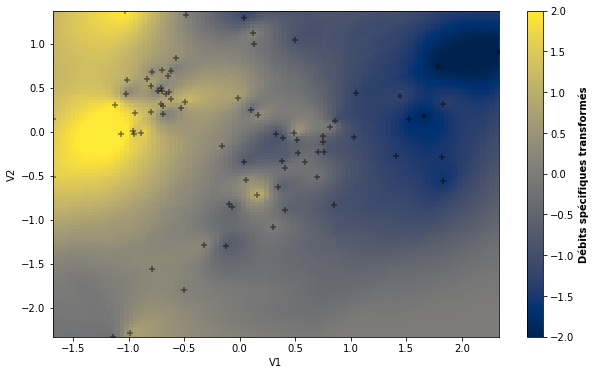

In [339]:
plt.figure(figsize=(10, 6))

cmap = plt.cm.cividis
VV = np.array(VV).reshape(XX.shape)

plt.pcolormesh(XX, YY, VV, cmap=cmap, vmin=-2, vmax=2)
xlim, ylim = plt.xlim(), plt.ylim()
cbar = plt.colorbar()
cbar.set_label("Débits spécifiques transformés", weight="bold")
plt.scatter(df["V1_cca"], df["V2_cca"], s=40, c="k", alpha=0.5, marker="+")
plt.xlim(xlim); plt.ylim(ylim)
plt.xlabel("V1")
plt.ylabel("V2")
plt.savefig("krigeage.jpg", format="jpg")

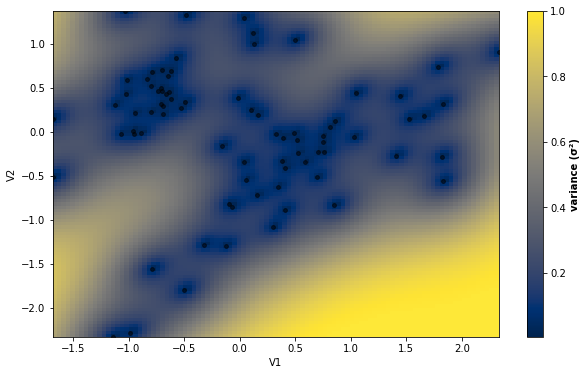

In [343]:
plt.figure(figsize=(10, 6))
VVariance = np.array(VVariance).reshape(XX.shape)



plt.pcolormesh(XX, YY, VVariance, cmap=cmap)
xlim, ylim = plt.xlim(), plt.ylim()
cbar = plt.colorbar()
plt.scatter(df["V1_cca"], df["V2_cca"], s=15, c="k", alpha=0.5)
cbar.set_label("variance (σ²)" ,weight="bold")
plt.xlim(xlim); plt.ylim(ylim)
plt.xlabel("V1")
plt.ylabel("V2")

plt.savefig("variance.jpg", format="jpg")

# 6. Cross validation

* cross validation leave one out to test the performance of the kriging model
* varied the ndmax argument in the kriging function to check how it affects the performance metrics

Note: ndmax is the use the set the maximum number of points to use for the kriging (neighbourhood)

In [344]:

ndmin = 0; ndmax = 10 


evaluation = [[], [], []]

for i in range(2, 79):
    ndmax = i
    v_krige = []
    for i in range(df.shape[0]):
        data = df.loc[df.index !=i].copy()
        dfloc = df.loc[df.index ==i].copy()

        v, _ = geostats.kb2d_locations(data, "V1_cca", "V2_cca", "ns_2ansq", -999, 999, 
                                                     dfloc, "V1_cca", "V2_cca", 
                                                     ndmin=ndmin, ndmax=ndmax, radius=20, 
                                                     ktype=1, skmean=0, vario=vario_cca)
        v_krige.append(v[0])
    v_krige = pd.DataFrame({"nscore_krige":v_krige})
    vk_bcktr = backtr_2ans(v_krige, "nscore_krige")
    vk_area = vk_bcktr * df["Sup_Diffus"]
    
    evaluation[0].append(root_mean_squared(df["2ans"], vk_area))
    evaluation[1].append(Bias(df["2ans"], vk_area))
    evaluation[2].append(Rroot_mean_squared(df["2ans"], vk_area)*100)

Working on location 0
  Estimated   1 blocks 
      average   0.7502916900228204  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.167630134209135  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.0825007566596994  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.25585377787033137  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.16885958627936964  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.7144666260266801  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5254738448472603  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.7995215725323377  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6216821561412181  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.2923159547821505  variance  0.0
Working on location 0
  Estimated

      average   0.9393757631510858  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.616310507784884  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6095814368473271  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.3765890227702524  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.7765206603592432  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.06356867406860571  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.1420215767460606  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5030974515771932  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6083228716198504  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.4961510815021297  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4859910958802572  va

  Estimated   1 blocks 
      average   1.7940191741788305  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.6227853484093204  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.5025208471636708  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.26639729407437845  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4381061299102875  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.044319354105435395  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.14139768494262805  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.46622208114675623  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.11438536416714118  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.10259932068184692  variance  0.0
Working on location 0
  Estimated   1 blocks 
    

Working on location 0
  Estimated   1 blocks 
      average   0.11567028587028588  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.31888700605938436  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.05728681569224059  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.6786556684289404  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.24066935933754993  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.12930505803458073  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9407230538828976  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.12479908625713726  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.01658837300293874  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.8869172913556  variance  0.0
Working on location 0
  Estimated 

  Estimated   1 blocks 
      average   0.5207107030294834  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.33850362227808667  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4788272149617485  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.38950314371286476  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.08557398018760108  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.7425100836086764  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.28707002779764274  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.5333947452575936  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.632719191630356  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.3643186306497024  variance  0.0
Working on location 0
  Estimated   1 blocks 
    

Working on location 0
  Estimated   1 blocks 
      average   1.6375787713473244  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.489589077065578  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.38050662328914564  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.58151427848284  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.18491231127553548  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.2662712684003355  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5656347664027263  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.08973890227425502  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.09389454142506444  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.14655066180681417  variance  0.0
Working on location 0
  Estimate

Working on location 0
  Estimated   1 blocks 
      average   0.6569145052711546  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.1237141885232215  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.622812998010293  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.019560397614524643  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3940186427013042  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.055316196140222984  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.8581691034993681  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.23522890164211577  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.17802809563951824  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9354236608376479  variance  0.0
Working on location 0
  Estimated 

Working on location 0
  Estimated   1 blocks 
      average   0.45630050474858086  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.483654623587503  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5172690907217402  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3360678689384715  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.45142079412479025  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.36690968354493786  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.08270535418479776  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.7254962400233406  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.309970914982498  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.5445606068173965  variance  0.0
Working on location 0
  Estimat

Working on location 0
  Estimated   1 blocks 
      average   -0.30850987196854174  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5721677430253007  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.17451741249770109  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.25752827492605407  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6371315200554383  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.14334990632922234  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.09140027715641284  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.11721328261805353  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.2995448687394456  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3665218170781859  variance  0.0
Working on location 0
  Es

Working on location 0
  Estimated   1 blocks 
      average   -0.012203651655894768  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9978925269138877  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6919036386348577  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6016263199154065  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.3439425306055142  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.8419911442897882  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.10113048753079258  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9550365603841201  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.8347982739943287  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6779247705064848  variance  0.0
Working on location 0
  Estimated   

Working on location 0
  Estimated   1 blocks 
      average   -0.33859574098738077  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.43755462845366416  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.36812558605027473  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.08963200951050222  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.7299805862205299  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3263576543402349  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.536909509269141  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.6268425591730544  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.339712699116045  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.569429513221504  variance  0.0
Working on location 0
  Estim

Working on location 0
  Estimated   1 blocks 
      average   1.5020500327298278  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3094473798007518  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.7304339185937855  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.1816455553589461  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.2611233306339895  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6315276591864699  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.12720385726280403  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.09440737191181417  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.09027035880162484  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.27939111368425174  variance  0.0
Working on location 0
  Estim

Working on location 0
  Estimated   1 blocks 
      average   -1.0332108307449295  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.3395319016725155  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.1997081316650116  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4971596576638482  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.34569192221723044  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6740769275101751  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.44762319969677977  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.056923828166896714  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5218938455523955  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6028929610783115  variance  0.0
Working on location 0
  Estim

Working on location 0
  Estimated   1 blocks 
      average   0.019909722016374986  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3275450907623197  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.10949019944711674  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.8461735407500444  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.22213299967216815  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.18882248649075778  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9756109416194856  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.061749676218840595  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.008311170927960077  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.001438059169483  variance  0.0
Working on location 0
  Estima

Working on location 0
  Estimated   1 blocks 
      average   0.6068487575589488  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.31984606011101  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.8296206221869831  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.13138480442016295  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.94946043351203  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.7908566494758833  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6664797971865855  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5216836215606765  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4201034736297775  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.4737310917491026  variance  0.0
Working on location 0
  Estimated   1 bloc

Working on location 0
  Estimated   1 blocks 
      average   -0.7266428762717291  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3333294020147094  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.545757189812529  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.635883727231987  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.4000498234102094  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.5904256444785276  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.57419809182157  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.9398146903957532  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.6946486788875086  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6197954366648466  variance  0.0
Working on location 0
  Estimated 

  Estimated   1 blocks 
      average   0.577232733710059  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5030994627656445  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5421830604026914  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.4845023613185533  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.3339624665433027  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.7681385341169042  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.6387662893205188  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.4988564153787567  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.30857240339507824  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.704292854153055  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average 

Working on location 0
  Estimated   1 blocks 
      average   0.24713434969516102  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.0215244015217169  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.3685704125916378  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.20354656066518653  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4702369175363641  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.36348694889091426  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6740670561166  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3013129894697666  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.05282331258889472  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5369883990018356  variance  0.0
Working on location 0
  Estimate

Working on location 0
  Estimated   1 blocks 
      average   0.4805773410494642  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.4541642622593118  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5156741847757998  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.33608433877102173  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4626712803872657  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3645513815790509  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.0919826539226223  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.7255338652137721  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3343841237836783  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.538887985211875  variance  0.0
Working on location 0
  Estimated

Working on location 0
  Estimated   1 blocks 
      average   1.3303310226989606  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.7809504792324302  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.6354312321358322  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.5053286979661318  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.2870651345728136  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.7081205260637813  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.1678613597524512  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.2570821102678852  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6171510928855749  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.142712013661163  variance  0.0
Working on location 0
  Estimated   1

Working on location 0
  Estimated   1 blocks 
      average   -0.25505753007711257  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.05637305944618705  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5313013277851737  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6362023192196807  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.10759353698198432  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5426852162501383  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.004235163970566688  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3506400705767574  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.02517155920570989  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.8834098847411522  variance  0.0
Working on location 0
  Estimat

  Estimated   1 blocks 
      average   -0.4277883173172156  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5273898245044155  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.4599186832944435  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5093731945571233  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3328791254054313  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.46132471046113216  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.36556055518981845  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.09739188697775104  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.7278264817384016  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.32467845723022576  variance  0.0
Working on location 0
  Estimated   1 blocks 
     

Working on location 0
  Estimated   1 blocks 
      average   0.48716093309121494  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5468592132094897  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.48059989811117493  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.3323481582531174  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.6997833585300144  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.6257801739641635  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.5136518719526582  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.28958461784691786  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6881734081791542  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.17386992563130313  variance  0.0
Working on location 0
  Estimate

Working on location 0
  Estimated   1 blocks 
      average   0.3662958370555347  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4722428235397136  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.0611535958371874  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.06536580273626123  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4539023686083057  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5309344850769361  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.5150062483039501  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6167277615544275  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.8024255730587828  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.2857039287877838  variance  0.0
Working on location 0
  Estimated

Working on location 0
  Estimated   1 blocks 
      average   0.0353742250672494  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.8430749478553567  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.23459144283171796  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.15635921220277008  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9676633226529205  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.03933514977706851  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.009376449751086204  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.96128541962381  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6779757897303537  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6045161392792281  variance  0.0
Working on location 0
  Estimated   

  Estimated   1 blocks 
      average   0.5037820043160853  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4441813507040604  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5523915219352874  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.4664591380096028  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5128876501399702  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.33182662613610425  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4610531627883397  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.36561275998247894  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.08932820828109007  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.727708586733151  variance  0.0
Working on location 0
  Estimated   1 blocks 
      av

  Estimated   1 blocks 
      average   1.3345358138730805  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.599741337467842  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.6237415365396735  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.5154294338901149  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.290988364172566  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.7016591894179286  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.1711954018726473  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.2572645234761585  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5609823552722538  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.13944536908945918  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average

  Estimated   1 blocks 
      average   -0.06382387663054916  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.45503689309565815  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.52978074141155  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.4923278706958996  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.403040166518393  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.8073526227624737  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.30957831973653654  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.0507546893935409  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.32320472017898927  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.20037440542705498  variance  0.0
Working on location 0
  Estimated   1 blocks 
      av

  Estimated   1 blocks 
      average   0.3112673813600956  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.0602695507903899  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.35255712272348616  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.19988927721604613  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.44984870937362526  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3509839559471423  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6743379853878249  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.19215882799992132  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.05718830439136772  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5387139133860166  variance  0.0
Working on location 0
  Estimated   1 blocks 
    

  Estimated   1 blocks 
      average   1.3431015192468867  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.8269470216919712  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.10899958151676399  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9236399874101962  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.8000985986223565  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6786270197078983  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5105268443352655  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.450977607547459  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5417549001144466  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.4649758649155917  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average  

Working on location 0
  Estimated   1 blocks 
      average   1.4648431172351524  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5005883971189522  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.33049502826630106  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.46009239145385916  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3660207216500293  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.09505116686936782  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.727443734713324  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3429438875069381  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.5204124041417322  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.6385071727962608  variance  0.0
Working on location 0
  Estima

  Estimated   1 blocks 
      average   -1.5486391701195037  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.637008678344502  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.3159371610693598  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.5911531711640547  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.4229904102048263  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.844253647964884  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.728441687919119  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5687293683579561  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.380868268580949  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.7506730306508432  variance  0.0
Working on location 0
  Estimated   1 blocks 
      avera

  Estimated   1 blocks 
      average   -0.5547147235824105  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.18761767615113023  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.10012864082984585  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.11586950636255505  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3147719685108803  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3637005116880582  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.3582173425872796  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.47259766553362414  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.0268536872112357  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.05784243941503671  variance  0.0
Working on location 0
  Estimated   1 blocks 
   

  Estimated   1 blocks 
      average   0.7914298813081114  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.32808069940294277  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.08201464059441  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.3316245379328198  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.21779155078154094  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4544102131171  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.34994483654651554  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6743750360999875  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.2122127791880505  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.05741896137720665  variance  0.0
Working on location 0
  Estimated   1 blocks 
      avera

  Estimated   1 blocks 
      average   -0.21857113091259217  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.057432761657758  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5396966364272008  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6150202320639166  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.1019781295076318  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5436121617978007  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.018877964712013074  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.373734978512294  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.07959522404595108  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.6641407535591026  variance  0.0
Working on location 0
  Estimated   1 blocks 
      aver

  Estimated   1 blocks 
      average   -0.009324470172849968  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9592854508523008  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6762070455121547  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6044227683073342  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.3469092378117704  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.827437385647514  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.10198785519108901  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9329380115347161  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.7997670415521162  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6788763164318844  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average

Working on location 0
  Estimated   1 blocks 
      average   0.8010661919708122  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6774790658503468  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5092218196177007  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.46072974717282467  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.600263920029436  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.462959609636109  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.49287800789248076  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.33048224512773294  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.458519842817232  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.36531390707486244  variance  0.0
Working on location 0
  Estimated  

Working on location 0
  Estimated   1 blocks 
      average   -1.3391196835879606  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.6074252299537912  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.4214555290375166  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.8563001100262981  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.7691538325537828  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5969191097068195  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.313262724925767  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.7507359002748865  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9310179405361435  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5722959866480751  variance  0.0
Working on location 0
  Estimated 

  Estimated   1 blocks 
      average   1.5129633918210306  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.2869285028291144  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6845903788582433  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.16728248308812232  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.2577119777030306  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5529691539361361  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.1823928012909701  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.11270153696833884  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.0972807918025537  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.31586183881826196  variance  0.0
Working on location 0
  Estimated   1 blocks 
      

  Estimated   1 blocks 
      average   -0.5282177830184204  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.4375853188538317  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.27112862135409155  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.7997649000563394  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.318923766480243  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.0586309136024015  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.3508258015786263  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.211617320484947  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.47848261837238876  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3630672249168394  variance  0.0
Working on location 0
  Estimated   1 blocks 
      aver

Working on location 0
  Estimated   1 blocks 
      average   -0.6718150819989686  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.18726810922954837  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.058244380424662595  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5377810913292937  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6280411649476266  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.10797382243048088  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5450358894492839  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.02597703207962817  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.19482474140077277  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.08386611382453904  variance  0.0
Working on location 0
  Esti

  Estimated   1 blocks 
      average   0.08396240986671824  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.6468967143551783  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.23354883927268819  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.16165969753108048  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.0027586172556517  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.024600403915169593  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.010642373206884692  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9686291353486032  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6783828662968545  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6052518352485329  variance  0.0
Working on location 0
  Estimated   1 blocks 
      av

  Estimated   1 blocks 
      average   0.03135449762155137  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.011337955202277735  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9693160626926104  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6790305528696926  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6053293475375282  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.3268227788943476  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.8269853421551548  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.06262129282223888  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9510825299952824  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.8041480690263864  variance  0.0
Working on location 0
  Estimated   1 blocks 
      avera

      average   1.3269099319185618  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.8269165473909105  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.048802897313258764  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9527145016753377  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.8030062734694915  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.679222138952065  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5112978026291831  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4446673025085952  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.58792263642166  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.442922035906255  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5051182003014336  varia

  Estimated   1 blocks 
      average   0.5087089148107484  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4414271990925887  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5880862669831604  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.4429578146550575  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5070146715975751  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3354071731695128  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4648902096579786  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3696165296859786  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.08672530653229955  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.7281203548182962  variance  0.0
Working on location 0
  Estimated   1 blocks 
      ave

  Estimated   1 blocks 
      average   -0.46250232291709636  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3671939628653966  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.08395350254558577  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.7277036945135603  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.34005821316982043  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.5512116151740114  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.635665687139186  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.2948901106012989  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.6050591240434338  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.4185815298392068  variance  0.0
Working on location 0
  Estimated   1 blocks 
    

Working on location 0
  Estimated   1 blocks 
      average   0.9429080318415197  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.573125817430607  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.3768506595941172  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5470293126352158  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.4773514307912522  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.3355126111359428  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.6333488589556475  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.627403347425157  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.5041473491179513  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.29336131143068056  variance  0.0
Working on location 0
  Estimated   1 b

  Estimated   1 blocks 
      average   -0.5497027318139162  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.19582113318463285  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.09674757790446052  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.09951082015357408  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3309953131126073  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3684797250153541  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.35744938811528965  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4818183046401848  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.0418513970549663  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.056933349286873706  variance  0.0
Working on location 0
  Estimated   1 blocks 
  

  Estimated   1 blocks 
      average   -0.4449311906512271  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5111990707691955  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.4424473243738178  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.18562469555624753  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.7927312682499811  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.2869113618636756  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.001293424245048  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.30724857569903363  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.2120965604499689  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5216111486300422  variance  0.0
Working on location 0
  Estimated   1 blocks 
      ave

  Estimated   1 blocks 
      average   -0.3582271401615603  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6853536074666158  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.09350154480217443  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.06348146891652506  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5395192706103855  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6325317028284237  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.0973735235152052  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5448311697774534  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.08415148679820512  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.06146885770944501  variance  0.0
Working on location 0
  Estimated   1 blocks 
      

  Estimated   1 blocks 
      average   0.0844095064650924  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.565829873111299  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.23746902984625365  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.16600200798379416  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.017278004024683  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.03808121877742958  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.012088733550012198  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9773246858422668  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6813948846792569  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6031666986843334  variance  0.0
Working on location 0
  Estimated   1 blocks 
      averag

  Estimated   1 blocks 
      average   0.9445912096573765  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.7868567314672829  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6774509640578883  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5072076941219118  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.44980109306766497  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5836396510150225  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.4282937861513227  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5056745672023116  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.33616796538074023  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.440054316904366  variance  0.0
Working on location 0
  Estimated   1 blocks 
      averag

Working on location 0
  Estimated   1 blocks 
      average   -1.257220879508678  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.6023151282352337  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.4079346774432298  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.862141502566142  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.8006091467574787  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5842097094915303  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.3081315141471255  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.7502337366927216  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.949289236727214  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5725617544296858  variance  0.0
Working on location 0
  Estimated   

  Estimated   1 blocks 
      average   -0.5441117000718554  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.47794297357740634  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.3359377074878522  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.5458131708343332  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.6232638438913294  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.5088481517947299  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.31722133225334725  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6762822827294709  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.15128873073950352  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.25507752423425917  variance  0.0
Working on location 0
  Estimated   1 blocks 
      av

  Estimated   1 blocks 
      average   -0.10764231085879433  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.31245925401768526  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3675664027802239  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.36454037172576803  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.48608705499931076  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.0510761738507761  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.06410147209825393  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4406588413341777  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5248528877618017  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.328189519507459  variance  0.0
Working on location 0
  Estimated   1 blocks 
   

Working on location 0
  Estimated   1 blocks 
      average   -0.5459185506039843  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.36611486202942434  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6808992446032833  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.11206136184817848  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.0481042792902831  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5346139677533985  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6211888425767533  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.09880778703691587  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.545528552153616  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.11740561860857687  variance  0.0
Working on location 0
  Estimat

Working on location 0
  Estimated   1 blocks 
      average   0.16664120905336566  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.0188350505569868  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.027515852161539334  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.011852642573717575  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9677764862471679  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6842488975495524  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.6036297574771802  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.3336668692137632  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.8250353809178528  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.021549300664098506  variance  0.0
Working on location 0
  Estimate

  Estimated   1 blocks 
      average   0.6777905922867019  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5086165477855128  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.42162411024666635  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5804521703378137  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.4310433729176817  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5258001378320003  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.32238453787879345  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4433859611845162  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3480825840575898  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.09628690865056352  variance  0.0
Working on location 0
  Estimated   1 blocks 
      av

Working on location 0
  Estimated   1 blocks 
      average   -0.09595746278390954  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.7264299044504177  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.33598326809919926  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.5613438645613658  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.6285037556197455  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.2063302879181348  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.5955020115207927  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.3824143491809968  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.8552042486532265  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.802045830655958  variance  0.0
Working on location 0
  Estim

  Estimated   1 blocks 
      average   -1.193801011000527  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.5919924028075343  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.3760009507970479  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.8531103781892027  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.8048696457901998  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6015934092181855  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.3010363116294137  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.7516504556038041  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.9373446497029124  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.5737942877267898  variance  0.0
Working on location 0
  Estimated   1 blocks 
      aver

Working on location 0
  Estimated   1 blocks 
      average   0.5735891578960416  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.3243643087869988  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.539931619307375  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.47807076124382425  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.3363971779985941  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.4070279990342636  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.6228839163252047  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.5110068336751905  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.30949999229846614  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.6697020989472486  variance  0.0
Working on location 0
  Estimated   

Working on location 0
  Estimated   1 blocks 
      average   -0.14520998205074373  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.2551723283323001  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5716650660273928  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.14802746362467847  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.09882036010066564  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.1617589625473235  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.3187552429370033  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.37267631971329646  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.3762943038422005  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.48593907776888284  variance  0.0
Working on location 0
  Esti

  Estimated   1 blocks 
      average   -0.3731403276727193  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.3761093728145534  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.4859722481760868  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.0613593737283233  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.05815186262017018  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.44833452563771414  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5209630043883006  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -1.084575866004747  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.008087273432169459  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.7486821526130745  variance  0.0
Working on location 0
  Estimated   1 blocks 
      

  Estimated   1 blocks 
      average   -0.007866689107851987  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.7360032225610389  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.2623038910105637  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.8994547118668885  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   0.3265702736952263  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.22476707610642155  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.5364343849553962  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.36025346338203523  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.683661598198844  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   -0.1001503713392275  variance  0.0
Working on location 0
  Estimated   1 blocks 
      

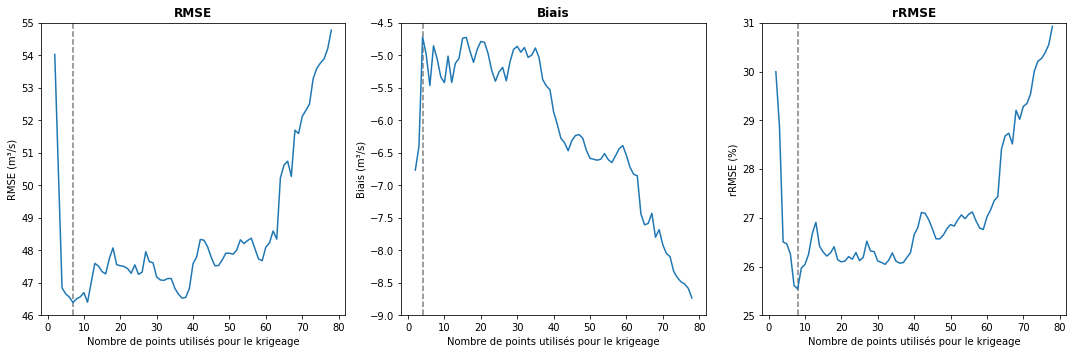

In [364]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(2, 79), evaluation[0], label="RMSE")
plt.vlines(range(2, 79)[np.argmin(evaluation[0])], 46, 55, ls="--", alpha=0.5)
plt.ylim(46, 55)
plt.title("RMSE", weight="bold")
plt.xlabel("Nombre de points utilisés pour le krigeage")
plt.ylabel("RMSE (m³/s)")
plt.subplot(132)
plt.plot(range(2, 79), evaluation[1], label="Biais")
plt.title("Biais", weight="bold")
plt.vlines(range(2, 79)[np.argmin(np.abs(evaluation[1]))], -9, -4.5, ls="--", alpha=0.5)
plt.ylim(-9, -4.5)
plt.xlabel("Nombre de points utilisés pour le krigeage")
plt.ylabel("Biais (m³/s)")
plt.subplot(133)
plt.plot(range(2, 79), evaluation[2], label="rRMSE %")
plt.vlines(range(2, 79)[np.argmin(np.abs(evaluation[2]))], 25, 31, ls="--", alpha=0.5)
plt.xlabel("Nombre de points utilisés pour le krigeage")
plt.ylabel("rRMSE (%)")
plt.ylim(25, 31)
plt.title("rRMSE", weight="bold")

plt.tight_layout(True)
plt.savefig("validation.jpg", format="jpg")

In [115]:
v_krige = pd.DataFrame({"nscore_krige":v_krige})
vk_bcktr = backtr_2ans(v_krige, "nscore_krige")
vk_area = vk_bcktr * df["Sup_Diffus"]

In [117]:
root_mean_squared(df["2ans"], vk_area), Bias(df["2ans"], vk_area), Rroot_mean_squared(df["2ans"], vk_area)*100

(46.698949965940145, -5.419655731172979, 26.04232231780374)

# 7. Application

* In this section we use the kriging model to estimate the quantile on ungauged site where a more traditional flood frequency analysis has been performed

In [131]:
#Application

df_appl = pd.read_csv("site_terrain_2020_gam.csv")

features = ["HISTO_4","P_mean", "HISTO_1", "Slope_mean"]

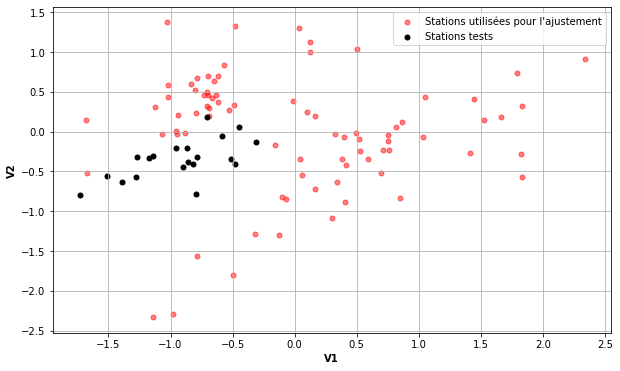

In [383]:
plt.figure(figsize=(10, 6))

X_appl = np.sqrt(df_appl[features])

X_appl_cca = cca.transform(X_appl)
df_appl["V1_cca"] = X_appl_cca[:, 0]
df_appl["V2_cca"] = X_appl_cca[:, 1]


plt.scatter(df["V1_cca"], df["V2_cca"], c="r", s=25, alpha=.5, label="Stations utilisées pour l'ajustement")
plt.scatter(df_appl["V1_cca"], df_appl["V2_cca"], c="k", s=25, alpha=1, label="Stations tests")
plt.xlabel("V1", weight="bold")
plt.ylabel("V2", weight="bold")
plt.grid(True)
plt.legend()
plt.savefig("stat_test.jpg", format="jpg")

In [385]:
q_appl, var_appl = geostats.kb2d_locations(df, "V1_cca", "V2_cca", "ns_2ansq", -999, 999,
                                           df_appl, "V1_cca", "V2_cca", 
                                                 ndmin=ndmin, ndmax=8, radius=20, 
                                                 ktype=1, skmean=0, vario=vario_cca )

df_appl["nscore_krige"] = q_appl

q_appl = backtr_2ans(df_appl, "nscore_krige") * df_appl["Area.km2"]
df_appl["2ans"] = q_appl

Working on location 0
Working on location 1
Working on location 2
Working on location 3
Working on location 4
Working on location 5
Working on location 6
Working on location 7
Working on location 8
Working on location 9
Working on location 10
Working on location 11
Working on location 12
Working on location 13
Working on location 14
Working on location 15
Working on location 16
Working on location 17
Working on location 18
Working on location 19
  Estimated   20 blocks 
      average   1.2326899547893717  variance  0.37547739811268377


In [389]:
AFR = [  5.10366847,   2.12252515,   0.45030463,   3.8638343 ,
         1.21013627,   0.53025592,   1.67288407,   5.78588464,
         2.6356757 ,   1.55381475,   3.96826539,   0.80747456,
        13.87166771,   9.29362861,   5.01336264,   3.7861146 ,
        11.70099262,  14.08461103,  14.87547692, 101.34003663]

print("Bias: "Bias(AFR, df_appl["2ans"]), 
      "RMSE:", root_mean_squared(AFR, df_appl["2ans"])," rRMSE:", Rroot_mean_squared(AFR, df_appl["2ans"]))

-0.1721033944368438

# 8. Sequential gaussian simulation (SGS)

* simulate 1000 realisations 
* estimates the confidence intervals 
* compare the results with the ones obtained through the more traditional flood frequency analysis

In [448]:
tmin = -999; tmax = 999
nx = 100; xmn = -1.68358105; xsiz = -0.04059267; ny = 100; ymn = --2.33265258; ysiz = 0.037457
nxdis = 1; nydis = 1  
ndmin = 0; ndmax = 10 
radius=100; nsim= 1
n = 1000
seed = np.random.randint(150, 28952, n)
all_real = []
for i in range(n):

    real = geostats.sgsim(df, "V1", "V2", "ns_2ansq", wcol=-1, scol=-1, twtcol=0,
                   tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,
                   tcol=0,zmin=-2, zmax=2, ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
                  nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=seed[i],
                  ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,
                   radius1=1,sang1=0,mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario_cca)
    
    all_real.append(real)


 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0873 (close to 0.0?)
                                   variance = 0.5626 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
      

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.147 (close to 0.0?)
                                   variance = 0.553 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curre

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0675 (close to 0.0?)
                                   variance = 0.5066 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0896 (close to 0.0?)
                                   variance = 0.5571 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1647 (close to 0.0?)
                                   variance = 0.6443 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0154 (close to 0.0?)
                                   variance = 0.632 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curre

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.1129 (close to 0.0?)
                                   variance = 0.4837 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1342 (close to 0.0?)
                                   variance = 0.5468 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.151 (close to 0.0?)
                                   variance = 0.618 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                           

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.109 (close to 0.0?)
                                   variance = 0.5445 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curre

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0352 (close to 0.0?)
                                   variance = 0.7061 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.003 (close to 0.0?)
                                   variance = 0.6197 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curre

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.026 (close to 0.0?)
                                   variance = 0.615 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                           

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.047 (close to 0.0?)
                                   variance = 0.7312 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0111 (close to 0.0?)
                                   variance = 0.6551 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0175 (close to 0.0?)
                                   variance = 0.5694 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0596 (close to 0.0?)
                                   variance = 0.6813 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0486 (close to 0.0?)
                                   variance = 0.5852 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0656 (close to 0.0?)
                                   variance = 0.5476 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.1004 (close to 0.0?)
                                   variance = 0.6521 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0042 (close to 0.0?)
                                   variance = 0.5688 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0297 (close to 0.0?)
                                   variance = 0.5745 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.1739 (close to 0.0?)
                                   variance = 0.5781 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0976 (close to 0.0?)
                                   variance = 0.6762 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1379 (close to 0.0?)
                                   variance = 0.4631 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1898 (close to 0.0?)
                                   variance = 0.612 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0217 (close to 0.0?)
                                   variance = 0.561 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0881 (close to 0.0?)
                                   variance = 0.5993 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1143 (close to 0.0?)
                                   variance = 0.5612 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0139 (close to 0.0?)
                                   variance = 0.5067 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0155 (close to 0.0?)
                                   variance = 0.8365 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1456 (close to 0.0?)
                                   variance = 0.5624 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0239 (close to 0.0?)
                                   variance = 0.6764 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1251 (close to 0.0?)
                                   variance = 0.4328 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1033 (close to 0.0?)
                                   variance = 0.5478 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1054 (close to 0.0?)
                                   variance = 0.6023 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0166 (close to 0.0?)
                                   variance = 0.4976 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.1294 (close to 0.0?)
                                   variance = 0.487 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curre

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0673 (close to 0.0?)
                                   variance = 0.6686 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.1787 (close to 0.0?)
                                   variance = 0.6615 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1469 (close to 0.0?)
                                   variance = 0.5075 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.049 (close to 0.0?)
                                   variance = 0.5814 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.103 (close to 0.0?)
                                   variance = 0.5733 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                          

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0087 (close to 0.0?)
                                   variance = 0.5742 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1057 (close to 0.0?)
                                   variance = 0.7582 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1026 (close to 0.0?)
                                   variance = 0.5784 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0832 (close to 0.0?)
                                   variance = 0.5822 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0455 (close to 0.0?)
                                   variance = 0.5051 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0725 (close to 0.0?)
                                   variance = 0.6805 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0368 (close to 0.0?)
                                   variance = 0.6685 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0032 (close to 0.0?)
                                   variance = 0.5662 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0243 (close to 0.0?)
                                   variance = 0.5806 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1243 (close to 0.0?)
                                   variance = 0.6638 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.026 (close to 0.0?)
                                   variance = 0.6883 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1351 (close to 0.0?)
                                   variance = 0.8392 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0374 (close to 0.0?)
                                   variance = 0.5574 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0058 (close to 0.0?)
                                   variance = 0.6823 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0978 (close to 0.0?)
                                   variance = 0.5202 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0773 (close to 0.0?)
                                   variance = 0.4791 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.274 (close to 0.0?)
                                   variance = 0.5376 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0063 (close to 0.0?)
                                   variance = 0.5506 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.1254 (close to 0.0?)
                                   variance = 0.6538 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0631 (close to 0.0?)
                                   variance = 0.6677 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0203 (close to 0.0?)
                                   variance = 0.6282 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.1756 (close to 0.0?)
                                   variance = 0.585 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                          

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1464 (close to 0.0?)
                                   variance = 0.6071 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1473 (close to 0.0?)
                                   variance = 0.7305 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0093 (close to 0.0?)
                                   variance = 0.6099 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0216 (close to 0.0?)
                                   variance = 0.577 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.1363 (close to 0.0?)
                                   variance = 0.644 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curre

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0377 (close to 0.0?)
                                   variance = 0.56 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                          

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0434 (close to 0.0?)
                                   variance = 0.6275 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0872 (close to 0.0?)
                                   variance = 0.7439 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.1195 (close to 0.0?)
                                   variance = 0.6533 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.2013 (close to 0.0?)
                                   variance = 0.6409 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1041 (close to 0.0?)
                                   variance = 0.5859 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0158 (close to 0.0?)
                                   variance = 0.675 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                          

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0474 (close to 0.0?)
                                   variance = 0.631 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curre

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0818 (close to 0.0?)
                                   variance = 0.499 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                          

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.05 (close to 0.0?)
                                   variance = 0.5643 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curre

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0924 (close to 0.0?)
                                   variance = 0.5316 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.2082 (close to 0.0?)
                                   variance = 0.6475 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0003 (close to 0.0?)
                                   variance = 0.6008 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0472 (close to 0.0?)
                                   variance = 0.5093 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.1207 (close to 0.0?)
                                   variance = 0.6831 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0594 (close to 0.0?)
                                   variance = 0.5767 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.1505 (close to 0.0?)
                                   variance = 0.5754 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.1866 (close to 0.0?)
                                   variance = 0.468 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curre

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0388 (close to 0.0?)
                                   variance = 0.5536 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1116 (close to 0.0?)
                                   variance = 0.6202 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0564 (close to 0.0?)
                                   variance = 0.5854 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1994 (close to 0.0?)
                                   variance = 0.5681 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0536 (close to 0.0?)
                                   variance = 0.5472 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0214 (close to 0.0?)
                                   variance = 0.5123 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0034 (close to 0.0?)
                                   variance = 0.6283 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0237 (close to 0.0?)
                                   variance = 0.6214 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.2062 (close to 0.0?)
                                   variance = 0.6711 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0321 (close to 0.0?)
                                   variance = 0.5173 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0052 (close to 0.0?)
                                   variance = 0.621 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0254 (close to 0.0?)
                                   variance = 0.4749 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0452 (close to 0.0?)
                                   variance = 0.5472 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1083 (close to 0.0?)
                                   variance = 0.7414 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0034 (close to 0.0?)
                                   variance = 0.5307 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                         

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0104 (close to 0.0?)
                                   variance = 0.6787 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   cur

   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1112 (close to 0.0?)
                                   variance = 0.5158 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                        

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0487 (close to 0.0?)
                                   variance = 0.574 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 80
                 Number trimmed                = 0
                 Weighted Average              = 0.0047
                 Weighted Variance             = 0.9625
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9842
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   curr

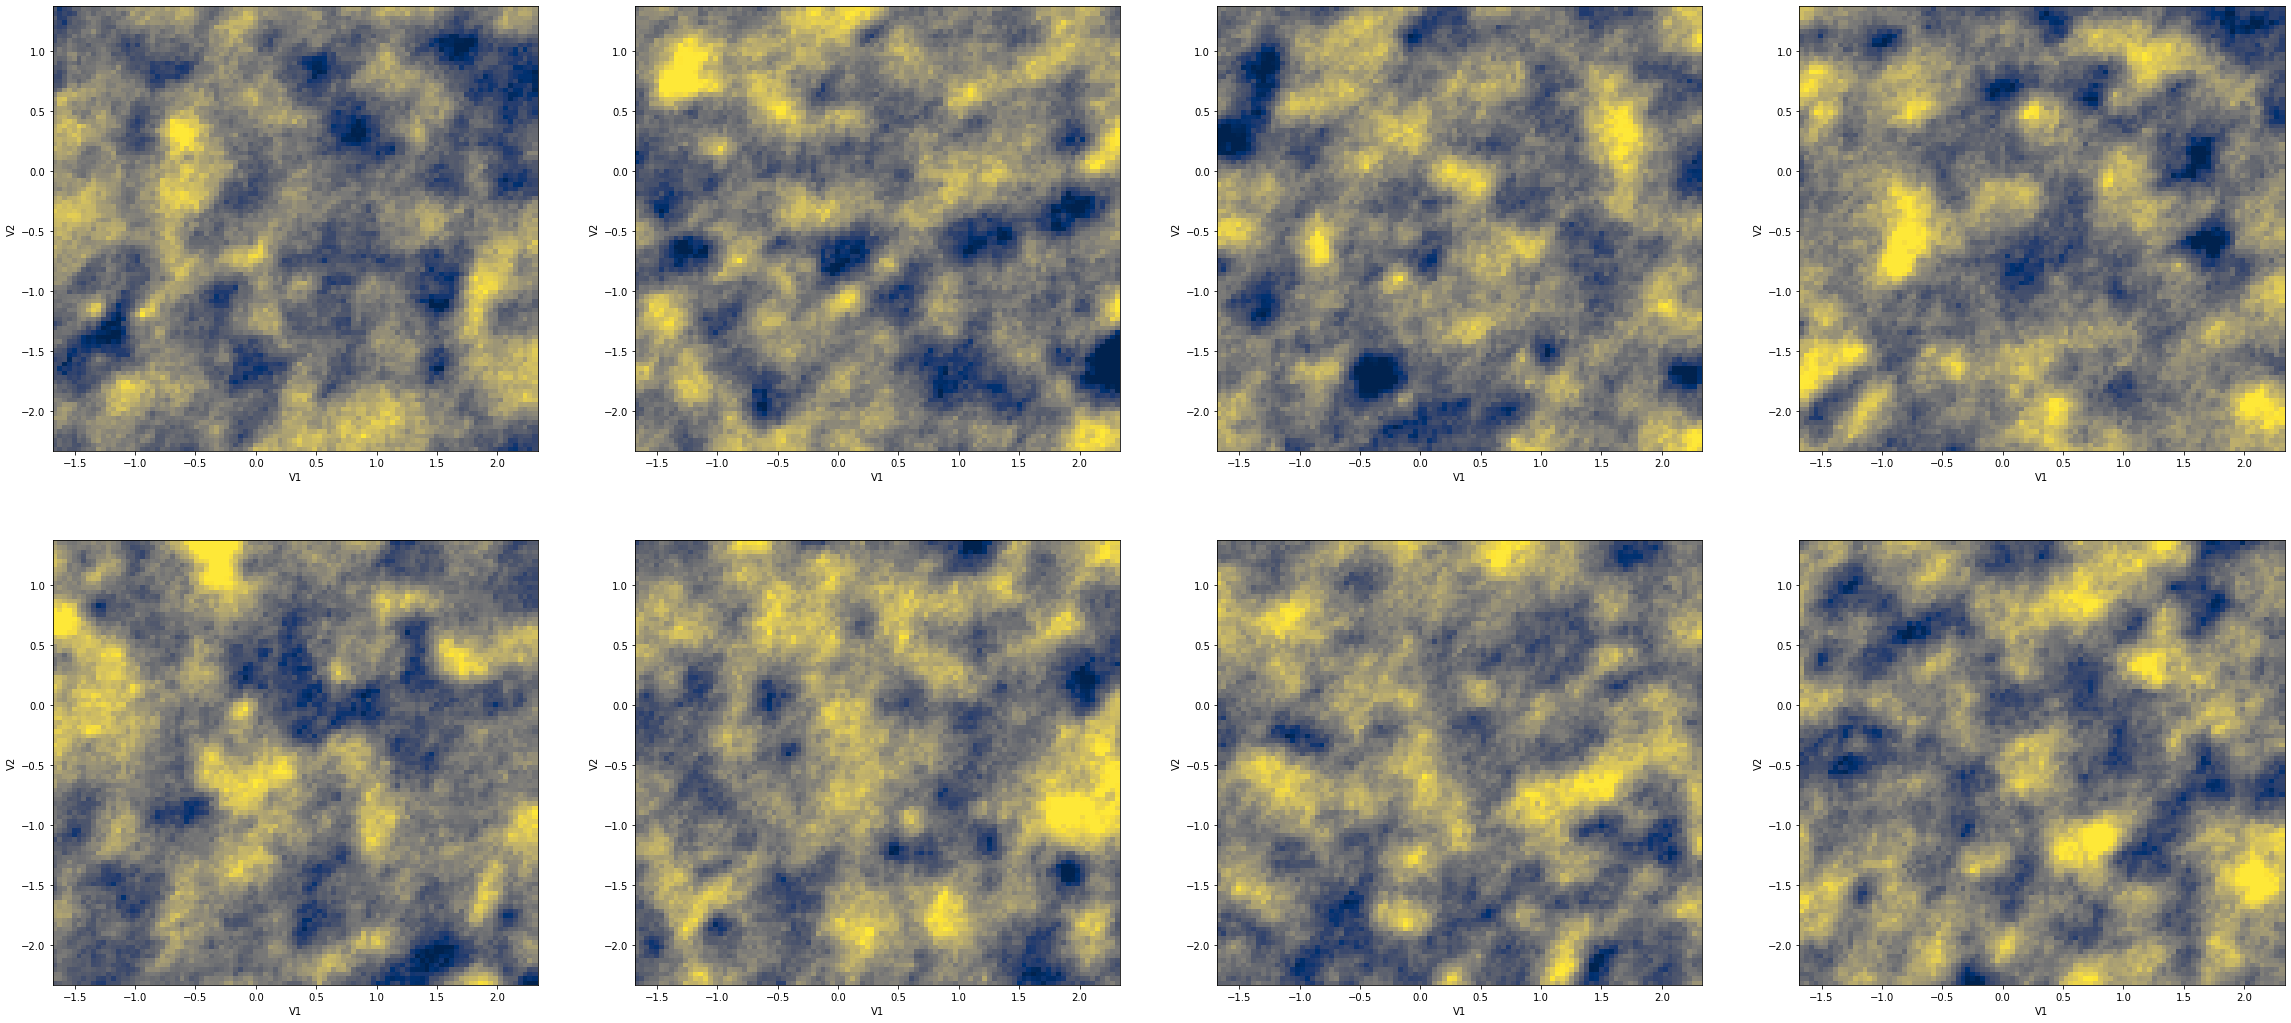

In [449]:
fig, axes = plt.subplots(2,4, figsize=(40, 18))

for i, ax in enumerate(axes.flatten()):
    ax.pcolormesh(XX, YY, all_real[i], cmap=cmap)
    ax.set_ylabel("V2")
    ax.set_xlabel("V1")

    
plt.savefig("SSG.jpg", format="jpg")
#plt.scatter(df["V1_cca"], df["V2_cca"])
#plt.scatter(df_appl["V1_cca"], df_appl["V2_cca"])

In [204]:
from scipy.spatial import cKDTree

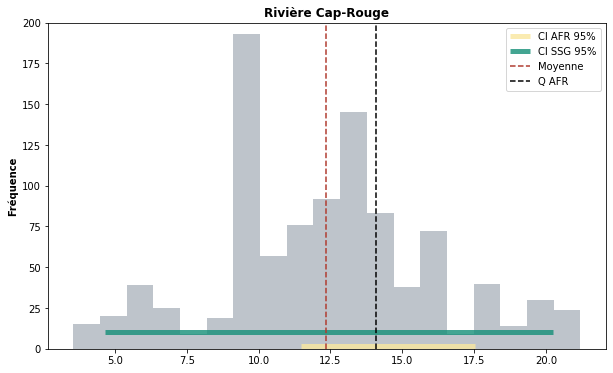

In [515]:

site = 17
tree = cKDTree(list(zip(XX.flatten(), YY.flatten())))
xy = df_appl[["V1_cca", "V2_cca"]].iloc[site]
Area = df_appl["Area.km2"].iloc[site]
d, ix = tree.query(xy)
val = np.array([all_real[i].flatten()[ix] for i in range(1000)])
val = pd.DataFrame({"nscore":val})

Qs = backtr_2ans(val, "nscore")

Q = Qs * Area

Ci_ssg = np.sort(Q)[[25, 975]]

plt.figure(figsize=(10,6))

plt.hist(Q, bins=np.linspace(Q.min(), Q.max(), 20), color="#5D6D7E", alpha=0.4)

plt.hlines(2, 11.47, 17.51, lw=5, color="#F9E79F", label="CI AFR 95%", alpha=.81)
plt.hlines(10, Ci_ssg[0], Ci_ssg[1], lw=5, color="#148F77", label="CI SSG 95%", alpha=0.8)
plt.vlines(Q.mean(), 0, 200, ls="--", color="#B03A2E", label="Moyenne")
plt.vlines(AFR[site], 0, 200, ls="--", color="k", label="Q AFR")
plt.ylim(0, 200)
#plt.grid(True)
plt.legend()
plt.title("Rivière Cap-Rouge", weight="bold")
plt.ylabel("Fréquence", weight="bold")
plt.savefig("Site_4.jpg", format="jpg")


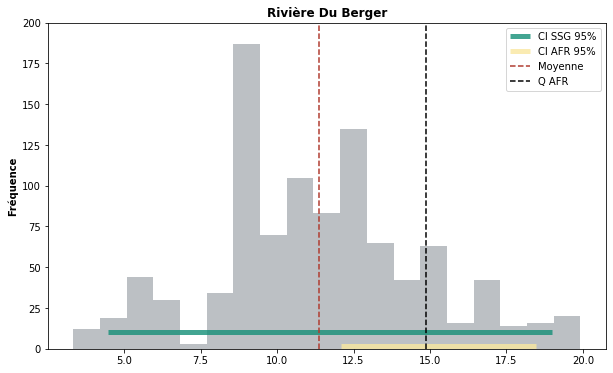

In [514]:
site = 18
tree = cKDTree(list(zip(XX.flatten(), YY.flatten())))
xy = df_appl[["V1_cca", "V2_cca"]].iloc[site]
Area = df_appl["Area.km2"].iloc[site]
d, ix = tree.query(xy)
val = np.array([all_real[i].flatten()[ix] for i in range(1000)])
val = pd.DataFrame({"nscore":val})

Qs = backtr_2ans(val, "nscore")

Q = Qs * Area
Ci_ssg = np.sort(Q)[[25, 975]]
plt.figure(figsize=(10,6))
plt.hist(Q, bins=np.linspace(Q.min(), Q.max(), 20), color="#212F3D", alpha=.3)

plt.hlines(10, Ci_ssg[0], Ci_ssg[1], lw=5, color="#148F77", label="CI SSG 95%", alpha=0.8)
plt.hlines(2, 12.106274, 18.47, lw=5, color="#F9E79F", label="CI AFR 95%", alpha=0.8)
plt.vlines(Q.mean(), 0, 300, ls="--", color="#B03A2E", label="Moyenne")
plt.vlines(AFR[site], 0, 300, ls="--", color="k", label="Q AFR")
plt.ylim(0, 200)
#plt.grid(True)
plt.legend()
plt.ylabel("Fréquence", weight="bold")
plt.title("Rivière Du Berger", weight="bold")
plt.savefig("site_9.jpg", format="jpg")